# Movie Recommender System

In simple terms, a recommender system is like a helpful friend that suggests things you might like. It's a computer program that looks at what you've enjoyed before and suggests similar things you might enjoy next.

**Business Problem**

In the fast-paced world we live in, we're flooded with countless choices, making it tough to decide. This overload can leave customers feeling stuck and businesses struggling to meet their goals like making sales or getting people interested.

That's where a recommender system steps in. It's like a friendly guide in the chaos, helping users find what matters most to them. By suggesting things they're likely to enjoy, it saves users time and boosts businesses' success metrics.

**Types**

Moving on from the old-school methods like "Top 10" lists or just showing what's popular or new. Big players like Amazon and Netflix have upgraded to more sophisticated techniques for suggesting stuff you'll like. Here are two main ones they use:

- Collaborative filtering
- Content-based

**Collaborative filtering (CF)**

CF algorithms are all about predicting how much a user will like something they haven't tried yet. They do this by looking at data on users, items, and the ratings users have given to items they've already tried.

Once they've made these predictions, CF algorithms can recommend things to users. They start by suggesting items they think a user will like the most, based on their predicted ratings, and then move down the list to items they think the user will like less.

CF comes in two flavors: 
- item-based (iCF)
- user-based (uCF)

In iCF, the algorithm focuses on a specific item and looks at other items that are similar to it. It predicts how much a user will like the item based on how much they liked similar items.

In uCF, the algorithm focuses on a specific user and looks at other users who are similar to them. It predicts how much the user will like an item based on how much similar users liked it.

When we talk about "similar items" or "similar users," it's not a simple yes or no thing. It's more like a spectrum. For any pair of items or users, we calculate a similarity score to see how much they resemble each other. The higher the score, the more alike they're considered. We do this calculation using vectors, which are just sets of numbers that represent each item or user. We'll dive into the specifics of these calculations later in the notebook.

Now, CF systems have a bit of a blind spot: they rely entirely on past interactions between users and items. This means they can struggle when there's a new item or user in the mix.

**Cold start (new item/new user) problem**

The cold start problem hits when the system doesn't know much about a new user or item. Here's how it plays out:
- New item: With iCF, since there's no data on the item yet, it's like starting with a blank slate. We can't compare it to other items to see what's similar. And with uCF, since no one has rated the item, we can't look at similar users' ratings to predict how much someone might like it.
- New user: With iCF, without any data on what similar users liked, it's hard to guess what a new user might enjoy. And in uCF, since the user's profile is empty, there's nothing to compare to other users to see who's similar.

To tackle the cold start problem with new items, one solution is to use the content-based technique.

**Content-based technique**

The CB technique takes a different approach. Instead of relying on past user-item interactions, it looks at the features of an item itself.

Here's how it works:

- When a new item comes in, we compare its features to those of every other item in the system. This helps us calculate a similarity score.
- Based on these scores, we figure out which existing items are most similar to the new one.
- Then, we can recommend the new item to users who've shown a liking for items similar to this new one.

So, with content-based recommendation, it's all about what the item is like, not how users have interacted with it before.

**Project Scope**

In the [previous project](https://github.com/adedamola26/meh-flix2.0/blob/main/lab/collabfiltering%20experiments.ipynb), we performed EDA on the _movie-lens-1m dataset_. We also performed hyperparameter tuning on several collaborative-filtering models and found `KNNBaseline(sim_options = {'name':'pearson_baseline','min_support':3,'user_based':False})` to be the best performing using the Root Means Square Error as our evaluation metric.

**Scope of this project**

Here we will build three content-based recommendation systems each based on a unique set of features (genres, directors & writers, and top cast). 

We’ll also improve on the work carried out on our item-based collaborative filtering recommendation system in the previous project.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

c:\Users\adeda\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
movies = pd.read_csv('movies.dat', delimiter='::', header=None, encoding='latin1')
movies.columns = ['movieId', 'title', 'genres']
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv('ratings.dat', delimiter='::', header=None, encoding='latin1', engine='python')
ratings.columns = ['userId', 'movieId', 'rating', 'timestamp']
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
links = pd.read_csv('links.csv', dtype={'imdbId': 'str'})
links.head()

,movieId,imdbId,tmdbId
0,1,0114709,862.0
1,2,0113497,8844.0
2,3,0113228,15602.0
3,4,0114885,31357.0
4,5,0113041,11862.0


In [5]:
movie_comp = pd.read_csv('movie_comp.csv', dtype = {'imdbId': 'str'})
movie_comp.head()

,imdbId,title,image,year,plot,directors,writers,top_cast
0,0073486,Einer flog über das Kuckucksnest,https://m.media-amazon.com/images/M/MV5BMDMwNj...,1975,"In the Fall of 1963, a Korean War veteran and ...",['Milos Forman'],"['Lawrence Hauben', 'Bo Goldman', 'Ken Kesey']","['Jack Nicholson', 'Louise Fletcher', 'Michael..."
1,0116683,James und der Riesenpfirsich,https://m.media-amazon.com/images/M/MV5BMTNkNW...,1996,An orphan who lives with his two cruel aunts b...,['Henry Selick'],"['Roald Dahl', 'Karey Kirkpatrick', 'Jonathan ...","['Paul Terry', 'Joanna Lumley', 'Pete Postleth..."
2,0058385,My Fair Lady,https://m.media-amazon.com/images/M/MV5BNGM0ZT...,1964,"In 1910s London, snobbish phonetics professor ...",['George Cukor'],"['Alan Jay Lerner', 'George Bernard Shaw']","['Audrey Hepburn', 'Rex Harrison', 'Stanley Ho..."
3,0195685,Erin Brockovich,https://m.media-amazon.com/images/M/MV5BYTA1NW...,2000,An unemployed single mother becomes a legal as...,['Steven Soderbergh'],['Susannah Grant'],"['Julia Roberts', 'Albert Finney', 'David Bris..."
4,0120623,Das große Krabbeln,https://m.media-amazon.com/images/M/MV5BNThmZG...,1998,"A misfit ant, looking for ""warriors"" to save h...","['John Lasseter', 'Andrew Stanton']","['John Lasseter', 'Andrew Stanton', 'Joe Ranft']","['Kevin Spacey', 'David Foley', 'Julia Louis-D..."


In [6]:
movies = movies.merge(links.drop('tmdbId', axis = 1), on='movieId')
movies.head()

,movieId,title,genres,imdbId
0,1,Toy Story (1995),Animation|Children's|Comedy,0114709
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0113497
2,3,Grumpier Old Men (1995),Comedy|Romance,0113228
3,4,Waiting to Exhale (1995),Comedy|Drama,0114885
4,5,Father of the Bride Part II (1995),Comedy,0113041


In [7]:
movie_comp = movie_comp.drop(['title', 'year'], axis = 1)
movie_comp.head()

,imdbId,image,plot,directors,writers,top_cast
0,0073486,https://m.media-amazon.com/images/M/MV5BMDMwNj...,"In the Fall of 1963, a Korean War veteran and ...",['Milos Forman'],"['Lawrence Hauben', 'Bo Goldman', 'Ken Kesey']","['Jack Nicholson', 'Louise Fletcher', 'Michael..."
1,0116683,https://m.media-amazon.com/images/M/MV5BMTNkNW...,An orphan who lives with his two cruel aunts b...,['Henry Selick'],"['Roald Dahl', 'Karey Kirkpatrick', 'Jonathan ...","['Paul Terry', 'Joanna Lumley', 'Pete Postleth..."
2,0058385,https://m.media-amazon.com/images/M/MV5BNGM0ZT...,"In 1910s London, snobbish phonetics professor ...",['George Cukor'],"['Alan Jay Lerner', 'George Bernard Shaw']","['Audrey Hepburn', 'Rex Harrison', 'Stanley Ho..."
3,0195685,https://m.media-amazon.com/images/M/MV5BYTA1NW...,An unemployed single mother becomes a legal as...,['Steven Soderbergh'],['Susannah Grant'],"['Julia Roberts', 'Albert Finney', 'David Bris..."
4,0120623,https://m.media-amazon.com/images/M/MV5BNThmZG...,"A misfit ant, looking for ""warriors"" to save h...","['John Lasseter', 'Andrew Stanton']","['John Lasseter', 'Andrew Stanton', 'Joe Ranft']","['Kevin Spacey', 'David Foley', 'Julia Louis-D..."


In [8]:
# leaving out rows with null values for images to avoid in-app
detailed_movies = movies.merge(movie_comp, on='imdbId').drop('movieId', axis = 1).dropna(subset = 'image').reset_index(drop=True)
detailed_movies.head()

,title,genres,imdbId,image,plot,directors,writers,top_cast
0,Toy Story (1995),Animation|Children's|Comedy,0114709,https://m.media-amazon.com/images/M/MV5BMDU2ZW...,A cowboy doll is profoundly threatened and jea...,['John Lasseter'],"['John Lasseter', 'Pete Docter', 'Andrew Stant...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim..."
1,Jumanji (1995),Adventure|Children's|Fantasy,0113497,https://m.media-amazon.com/images/M/MV5BZTk2Zm...,When two kids find and play a magical board ga...,['Joe Johnston'],"['Jonathan Hensleigh', 'Greg Taylor', 'Jim Str...","['Robin Williams', 'Kirsten Dunst', 'Bonnie Hu..."
2,Grumpier Old Men (1995),Comedy|Romance,0113228,https://m.media-amazon.com/images/M/MV5BMDkwYT...,John and Max resolve to save their beloved bai...,['Howard Deutch'],['Mark Steven Johnson'],"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret..."
3,Waiting to Exhale (1995),Comedy|Drama,0114885,https://m.media-amazon.com/images/M/MV5BYzcyMD...,"Based on Terry McMillan's novel, this film fol...",['Forest Whitaker'],"['Terry McMillan', 'Ron Bass']","['Whitney Houston', 'Angela Bassett', 'Loretta..."
4,Father of the Bride Part II (1995),Comedy,0113041,https://m.media-amazon.com/images/M/MV5BYTZiND...,George Banks must deal not only with his daugh...,['Charles Shyer'],"['Albert Hackett', 'Frances Goodrich', 'Nancy ...","['Steve Martin', 'Diane Keaton', 'Martin Short..."


In [9]:
n_movies = detailed_movies['imdbId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 3675 unique movies in our movies dataset.


### Content-based recommendation

__Genre-based__

In [10]:
detailed_movies['genres'] = detailed_movies['genres'].apply(lambda x : x.split('|'))
detailed_movies.head()

,title,genres,imdbId,image,plot,directors,writers,top_cast
0,Toy Story (1995),"[Animation, Children's, Comedy]",0114709,https://m.media-amazon.com/images/M/MV5BMDU2ZW...,A cowboy doll is profoundly threatened and jea...,['John Lasseter'],"['John Lasseter', 'Pete Docter', 'Andrew Stant...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim..."
1,Jumanji (1995),"[Adventure, Children's, Fantasy]",0113497,https://m.media-amazon.com/images/M/MV5BZTk2Zm...,When two kids find and play a magical board ga...,['Joe Johnston'],"['Jonathan Hensleigh', 'Greg Taylor', 'Jim Str...","['Robin Williams', 'Kirsten Dunst', 'Bonnie Hu..."
2,Grumpier Old Men (1995),"[Comedy, Romance]",0113228,https://m.media-amazon.com/images/M/MV5BMDkwYT...,John and Max resolve to save their beloved bai...,['Howard Deutch'],['Mark Steven Johnson'],"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret..."
3,Waiting to Exhale (1995),"[Comedy, Drama]",0114885,https://m.media-amazon.com/images/M/MV5BYzcyMD...,"Based on Terry McMillan's novel, this film fol...",['Forest Whitaker'],"['Terry McMillan', 'Ron Bass']","['Whitney Houston', 'Angela Bassett', 'Loretta..."
4,Father of the Bride Part II (1995),[Comedy],0113041,https://m.media-amazon.com/images/M/MV5BYTZiND...,George Banks must deal not only with his daugh...,['Charles Shyer'],"['Albert Hackett', 'Frances Goodrich', 'Nancy ...","['Steve Martin', 'Diane Keaton', 'Martin Short..."


In [11]:
from collections import Counter
# getting the count for each genre
genre_freq = Counter([g for G in detailed_movies['genres'] for g in G])
genre_freq

Counter({'Drama': 1481,
         'Comedy': 1157,
         'Action': 492,
         'Thriller': 479,
         'Romance': 459,
         'Horror': 333,
         'Adventure': 280,
         'Sci-Fi': 270,
         "Children's": 246,
         'Crime': 201,
         'War': 137,
         'Musical': 112,
         'Documentary': 110,
         'Mystery': 103,
         'Animation': 100,
         'Fantasy': 68,
         'Western': 67,
         'Film-Noir': 44})

In [12]:
genres = genre_freq.keys()
genres

dict_keys(['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir', 'Western'])

In [13]:
movie_genres = detailed_movies[['imdbId', 'title', 'genres']]
movie_genres.head()

,imdbId,title,genres
0,0114709,Toy Story (1995),"[Animation, Children's, Comedy]"
1,0113497,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,0113228,Grumpier Old Men (1995),"[Comedy, Romance]"
3,0114885,Waiting to Exhale (1995),"[Comedy, Drama]"
4,0113041,Father of the Bride Part II (1995),[Comedy]


In [14]:
# iterates through each genre, creates a new column for each with row value '1' indicating that the movie is of that genre and '0' indicating otherwise
for g in genres:
    movie_genres[g] = movie_genres['genres'].apply(lambda x: int(g in x))
movie_genres_sparse = movie_genres.drop(['imdbId', 'title', 'genres'], axis = 1)
movie_genres_sparse.head()

,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
from sklearn.metrics.pairwise import cosine_similarity
# stores a matrix of cosine similarity values between each pair of movies
cosine_sim_genre = cosine_similarity(movie_genres_sparse, movie_genres_sparse)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim_genre.shape}")

Dimensions of our genres cosine similarity matrix: (3675, 3675)


In [16]:
from fuzzywuzzy import process
# returns the closest match to the input title
def movie_finder(title):
    all_titles = detailed_movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]
movie_finder('tom story')

'Toy Story (1995)'

In [17]:
# creates a dictionary with movie titles as keys and respective indices as values
# allows us to find the movie's index in the cosine similarity matrix
idx_genres = dict(zip(movie_genres['title'], movie_genres.index))

In [18]:
def get_content_based_recommendations_genres(title_string, n_recommendations=10):
    """
    Returns 'n_recommendations' recommendations for a given movie

    Args:
        title_string (str): The title of the movie for which you want recommendations
        n_recommendations (int): The number of recommendations you want; default is 10
    """
    title = movie_finder(title_string)
    idx = idx_genres[title]
    sim_scores = list(enumerate(cosine_sim_genre[idx]))
    sim_scores.pop(idx)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[:n_recommendations]
    similar_movies = [i[0] for i in sim_scores]
    rec_movies = movie_genres['title'].iloc[similar_movies].tolist()
    print(f"Because you watched {title}:")
    return sim_scores, rec_movies

In [19]:
toy_story_recomm_g = get_content_based_recommendations_genres('toy story', 10)
toy_story_recomm_g[1]

Because you watched Toy Story (1995):


['American Tail, An (1986)',
 'American Tail: Fievel Goes West, An (1991)',
 'Rugrats Movie, The (1998)',
 "Bug's Life, A (1998)",
 'Toy Story 2 (1999)',
 'Saludos Amigos (1943)',
 'Chicken Run (2000)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 'Goofy Movie, A (1995)',
 'Aladdin (1992)']

Someone who knows their movies can tell that the recommendations are relevant for a lover of _Toy Story I_.

For others we can compare the similarity scores and common genres to better understand why such recommendations were made.

In [20]:
toy_story_recomm_g[0]

[(1940, 1.0000000000000002),
 (1941, 1.0000000000000002),
 (2141, 1.0000000000000002),
 (2142, 1.0000000000000002),
 (2876, 1.0000000000000002),
 (3344, 1.0000000000000002),
 (3479, 1.0000000000000002),
 (3482, 1.0000000000000002),
 (232, 0.8660254037844388),
 (570, 0.8660254037844388)]

From the next cell's output, we can tell that all movies having the same similarity score as Toy Story I (shown in the preceeding cell) have the same combination of genres.

`232` and `570` have additional genres, hence the lower similarity scores.

In [21]:
movie_genres[movie_genres['title'].isin(toy_story_recomm_g[1])][['title', 'genres']]

,title,genres
232,"Goofy Movie, A (1995)","[Animation, Children's, Comedy, Romance]"
570,Aladdin (1992),"[Animation, Children's, Comedy, Musical]"
1940,"American Tail, An (1986)","[Animation, Children's, Comedy]"
1941,"American Tail: Fievel Goes West, An (1991)","[Animation, Children's, Comedy]"
2141,"Rugrats Movie, The (1998)","[Animation, Children's, Comedy]"
2142,"Bug's Life, A (1998)","[Animation, Children's, Comedy]"
2876,Toy Story 2 (1999),"[Animation, Children's, Comedy]"
3344,Saludos Amigos (1943),"[Animation, Children's, Comedy]"
3479,Chicken Run (2000),"[Animation, Children's, Comedy]"
3482,"Adventures of Rocky and Bullwinkle, The (2000)","[Animation, Children's, Comedy]"


**Why was `sim_scores.pop(idx)` was necessary in `get_content_based_recommendations_genres`?**

It's easy to assume that the movie of interest (MOI) will be the first element in `sim_scores` after sorting with `sorted(sim_scores, key=lambda x: x[1], reverse=True)`. 

It will then mean slicing with `[1:n_recommendations+1]` will yield our desired outcome but in our genre dataset, where several movies have exactly the same features, there is bound to be many cases where there are ties in similarity scores. 

`sorted` breaks these ties by maintaining the order in the original list (example shown in the next cell).

Hence the necessity to first remove the MOI from the list with `sim_scores.pop(idx)`.

In [22]:
sorted(list(enumerate(cosine_sim_genre[117])), key=lambda x: x[1], reverse=True)[:11]

[(2, 0.9999999999999998),
 (6, 0.9999999999999998),
 (38, 0.9999999999999998),
 (62, 0.9999999999999998),
 (66, 0.9999999999999998),
 (90, 0.9999999999999998),
 (113, 0.9999999999999998),
 (117, 0.9999999999999998),
 (124, 0.9999999999999998),
 (229, 0.9999999999999998),
 (230, 0.9999999999999998)]

**Directors & writers based**

In [23]:
# drop row with null values for 'directors' and 'writers'
movie_dw = detailed_movies[['title', 'directors', 'writers']].dropna().reset_index(drop=True)
movie_dw.head()

,title,directors,writers
0,Toy Story (1995),['John Lasseter'],"['John Lasseter', 'Pete Docter', 'Andrew Stant..."
1,Jumanji (1995),['Joe Johnston'],"['Jonathan Hensleigh', 'Greg Taylor', 'Jim Str..."
2,Grumpier Old Men (1995),['Howard Deutch'],['Mark Steven Johnson']
3,Waiting to Exhale (1995),['Forest Whitaker'],"['Terry McMillan', 'Ron Bass']"
4,Father of the Bride Part II (1995),['Charles Shyer'],"['Albert Hackett', 'Frances Goodrich', 'Nancy ..."


In [24]:
import ast
# converts string representation of lists to actual lists
movie_dw['directors'] = movie_dw['directors'].apply(ast.literal_eval)
movie_dw['writers'] = movie_dw['writers'].apply(ast.literal_eval)

In [25]:
dir_frequ = Counter(d for D in movie_dw['directors'] for d in D)
sorted(dir_frequ.items(), key= lambda x:x[1], reverse= True)[:5]

[('Alfred Hitchcock', 46),
 ('Woody Allen', 20),
 ('Spike Lee', 14),
 ('Steven Spielberg', 14),
 ('Robert Stevenson', 14)]

In [26]:
wri_freq = Counter (w for W in movie_dw['writers'] for w in W)
sorted(wri_freq.items(), key=lambda x: x[1], reverse = True)[:5]

[('Stephen King', 31),
 ('William Shakespeare', 20),
 ('Woody Allen', 20),
 ('John Hughes', 17),
 ('David Mamet', 14)]

In [27]:
# some directors are also writers so we'll differentiate their roles in each movie with the 'dir_' and 'wri_' prefixes
movie_dw['directors'] = movie_dw['directors'].apply(lambda x: [f'dir_{y}' for y in x])
movie_dw['writers'] = movie_dw['writers'].apply(lambda x: [f'wri_{y}' for y in x])


directors = set(d for D in movie_dw['directors'] for d in D)
writers = set(w for W in movie_dw['writers'] for w in W)

In [28]:
for d in directors:
    movie_dw[d] = movie_dw['directors'].apply(lambda x: int(d in x))
for w in writers:
    movie_dw[w] = movie_dw['writers'].apply(lambda x: int(w in x))
movie_dw_sparse = movie_dw.drop(['directors', 'writers', 'title'], axis = 1)
movie_dw_sparse.head()

,dir_Walter Lang,dir_James D.R. Hickox,dir_Paul Brizzi,dir_Tommy Lee Wallace,dir_Bertrand Blier,dir_Mira Nair,dir_Mel Gibson,dir_Jim McBride,dir_Jun Falkenstein,dir_Takeshi Kitano,...,wri_Becky Johnston,wri_Moss Hart,wri_Philip LaZebnik,wri_Ariane Schluter,wri_Sharon Pollack,wri_Ann Leary,wri_Joan Claire Chabriel,wri_Matthew Chapman,wri_Robert C. Thompson,wri_Luc Besson
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
cosine_sim_dw = cosine_similarity(movie_dw_sparse, movie_dw_sparse)
print(f"Dimensions of our dXw cosine similarity matrix: {cosine_sim_dw.shape}")

Dimensions of our dXw cosine similarity matrix: (3675, 3675)


In [30]:
idx_dw = dict(zip(movie_dw['title'], movie_dw.index))

In [31]:
def get_content_based_recommendations_dw(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = idx_dw[title]
    sim_scores = list(enumerate(cosine_sim_dw[idx]))
    sim_scores.pop(idx)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[:n_recommendations]
    similar_movies = [i[0] for i in sim_scores]
    rec_movies = movie_dw['title'].iloc[similar_movies]
    print(f"Because you watched {title}:")
    return sim_scores, rec_movies

In [32]:
toy_story_recomm_dw = get_content_based_recommendations_dw('toy story', 10)
toy_story_recomm_dw[1]

Because you watched Toy Story (1995):


2142                  Bug's Life, A (1998)
2876                    Toy Story 2 (1999)
1                           Jumanji (1995)
2                  Grumpier Old Men (1995)
3                 Waiting to Exhale (1995)
4       Father of the Bride Part II (1995)
5                              Heat (1995)
6                           Sabrina (1995)
7                      Tom and Huck (1995)
8                      Sudden Death (1995)
Name: title, dtype: object

If we pay attention to the indeces (above) of the 3rd to 10th recommended movies, it's safe to assume that it's unlikely the 3rd-10th most similar movies are all ordered in the same way in our dataset.

If we examine the similarity scores in the next cell, we can see that these movies have no similarity based on the features used (directors and writers). 



In [33]:
# only two movies with similarity score higher than 0
toy_story_recomm_dw[0]

[(2142, 0.6708203932499369),
 (2876, 0.6123724356957946),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (7, 0.0),
 (8, 0.0)]

The only two movies with some degree of similarity are movies by the makers of _Toy Story I_.



In [34]:
movie_dw.loc[0, :]['directors'], movie_dw.loc[0, :]['writers'] # Toy Story (1995)

(['dir_John Lasseter'],
 ['wri_John Lasseter', 'wri_Pete Docter', 'wri_Andrew Stanton'])

We may notice that _Toy Story 2_ is ranked as less than _A Bug's Life_ because the latter has more common features with _Toy Story I_ than the former.

In [35]:
movie_dw.loc[2142, :]['directors'], movie_dw.loc[2142, :]['writers'] # Bug's Life, A (1998)

(['dir_John Lasseter', 'dir_Andrew Stanton'],
 ['wri_John Lasseter', 'wri_Andrew Stanton', 'wri_Joe Ranft'])

In [36]:
movie_dw.loc[2876, :]['directors'], movie_dw.loc[2876, :]['writers'] # Toy Story 2

(['dir_John Lasseter', 'dir_Ash Brannon', 'dir_Lee Unkrich'],
 ['wri_John Lasseter', 'wri_Pete Docter', 'wri_Ash Brannon'])

This issue of having only a few movies with similarity scores higher than 0 is due to our DW dataset having 6662 features and each movie having a maximum of only 6 features (shown in next cell) with a value of '1'.

In [37]:
max_dir_count = movie_dw.writers.apply(lambda x: len(x)).max() 
max_wri_count = movie_dw.directors.apply(lambda x: len(x)).max()
print(f'The maximum number of directors and writers for any given movie is {max_dir_count + max_wri_count}.')

The maximum number of directors and writers for any given movie is 6.


This problem will likely be common to many movies since the probability of any two movies having just one feature commonly having a value of '1' is close to zero (i.e. `1/6662`)

The movies that may produce more relevant recommendations (i.e. more movies with similarity scores greater than 0) are movies that are part of series which tend to have common directors and writers like _Star Trek_ (shown in the next cell) which has at least 8 parts in our dataset.

In [38]:
get_content_based_recommendations_dw('star trek', 10)[1]

Because you watched Star Trek: Generations (1994):


1244                  Star Trek: First Contact (1996)
2180                   Star Trek: Insurrection (1998)
1261       Star Trek III: The Search for Spock (1984)
1257             Star Trek: The Motion Picture (1979)
1258    Star Trek VI: The Undiscovered Country (1991)
1259           Star Trek V: The Final Frontier (1989)
1260              Star Trek: The Wrath of Khan (1982)
1262             Star Trek IV: The Voyage Home (1986)
3356                     Mission: Impossible 2 (2000)
0                                    Toy Story (1995)
Name: title, dtype: object

In [39]:
# getting the similarity scores of recommended movies
get_content_based_recommendations_dw('star trek', 10)[0]

Because you watched Star Trek: Generations (1994):


[(1244, 0.5),
 (2180, 0.5),
 (1261, 0.2886751345948129),
 (1257, 0.25),
 (1258, 0.25),
 (1259, 0.25),
 (1260, 0.25),
 (1262, 0.25),
 (3356, 0.25),
 (0, 0.0)]

We can safely say that using the directors and writers alone to recommend movies is unreliable and can cause issues like including movies with adult content like _Sabrina_ to minors who may be users showing the most interest in _Children/Animation_ movies like _Toy Story_.

In [40]:
movie_genres[movie_genres['title'].isin(toy_story_recomm_dw[1])][['title', 'genres']]

,title,genres
1,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,Grumpier Old Men (1995),"[Comedy, Romance]"
3,Waiting to Exhale (1995),"[Comedy, Drama]"
4,Father of the Bride Part II (1995),[Comedy]
5,Heat (1995),"[Action, Crime, Thriller]"
6,Sabrina (1995),"[Comedy, Romance]"
7,Tom and Huck (1995),"[Adventure, Children's]"
8,Sudden Death (1995),[Action]
2142,"Bug's Life, A (1998)","[Animation, Children's, Comedy]"
2876,Toy Story 2 (1999),"[Animation, Children's, Comedy]"


**Top Cast based**

In [41]:
movie_actors = detailed_movies[['title', 'top_cast']].dropna().reset_index(drop=True)
movie_actors.head()

,title,top_cast
0,Toy Story (1995),"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim..."
1,Jumanji (1995),"['Robin Williams', 'Kirsten Dunst', 'Bonnie Hu..."
2,Grumpier Old Men (1995),"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret..."
3,Waiting to Exhale (1995),"['Whitney Houston', 'Angela Bassett', 'Loretta..."
4,Father of the Bride Part II (1995),"['Steve Martin', 'Diane Keaton', 'Martin Short..."


In [42]:
# convert string representation of list to actual list
movie_actors['top_cast'] = movie_actors['top_cast'].apply(ast.literal_eval) 

In [43]:
actors_freq = Counter(a for A in movie_actors['top_cast'] for a in A)
sorted(actors_freq.items(), key = lambda x : x[1], reverse = True)[:5]

[('Robert De Niro', 33),
 ('Samuel L. Jackson', 30),
 ('Whoopi Goldberg', 30),
 ('Dan Hedaya', 28),
 ('Robert Duvall', 28)]

In [44]:
all_actors = actors_freq.keys()
all_actors

dict_keys(['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim Varney', 'Wallace Shawn', 'John Ratzenberger', 'Annie Potts', 'John Morris', 'Erik von Detten', 'Laurie Metcalf', 'R. Lee Ermey', 'Sarah Rayne', 'Penn Jillette', 'Jack Angel', 'Spencer Aste', 'Greg Berg', 'Lisa Bradley', 'Kendall Cunningham', 'Robin Williams', 'Kirsten Dunst', 'Bonnie Hunt', 'Jonathan Hyde', 'Bradley Pierce', 'Bebe Neuwirth', 'David Alan Grier', 'Patricia Clarkson', 'Adam Hann-Byrd', 'Laura Bell Bundy', 'James Handy', 'Gillian Barber', 'Brandon Obray', 'Cyrus Thiedeke', 'Gary Joseph Thorup', 'Leonard Zola', 'Lloyd Berry', 'Malcolm Stewart', 'Walter Matthau', 'Jack Lemmon', 'Ann-Margret', 'Sophia Loren', 'Burgess Meredith', 'Daryl Hannah', 'Kevin Pollak', 'Katie Sagona', 'Ann Morgan Guilbert', 'James Andelin', 'Marcus Klemp', 'Max Wright', 'Cheryl Hawker', 'Wayne A. Evenson', 'Allison Levine', 'John Patrick Martin', 'Adam Ward', 'Ryan Waldoch', 'Whitney Houston', 'Angela Bassett', 'Loretta Devine', 'Lela Rochon', 

In [45]:
for a in all_actors:
    movie_actors[a] = movie_actors['top_cast'].apply(lambda x : int(a in x))
movie_actors_sparse = movie_actors.drop(['title', 'top_cast'], axis = 1)
movie_actors_sparse.head()

,Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wallace Shawn,John Ratzenberger,Annie Potts,John Morris,Erik von Detten,Laurie Metcalf,...,Haven Gaston,Matt Servitto,Michele Santopietro,Anthony Arkin,Sharon Angela,Nick Tosches,Kristen Shaw,Douglas Urbanski,Noah Fryrear,Kevin Geer
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
idx_actors = dict(zip(movie_actors['title'], movie_actors.index))

In [47]:
cosine_sim_actors = cosine_similarity(movie_actors_sparse, movie_actors_sparse)
print(f"Dimensions of our actors cosine similarity matrix: {cosine_sim_actors.shape}")

Dimensions of our actors cosine similarity matrix: (3675, 3675)


In [48]:
def get_content_based_recommendations_actors(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = idx_actors[title]
    sim_scores = list(enumerate(cosine_sim_actors[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[:(n_recommendations+5)] 
    sim_scores = [movie for movie in sim_scores if movie[0] != idx]
    sim_scores = sim_scores[:n_recommendations]
    similar_movies = [i[0] for i in sim_scores]
    rec_movies = movie_actors['title'].iloc[similar_movies]
    print(f"Because you watched {title}:")
    return sim_scores, rec_movies

In [49]:
toy_story_actors_rec = get_content_based_recommendations_actors('toy story', 10)
movie_genres[movie_genres['title'].isin(toy_story_actors_rec[1])][['title', 'genres']]

Because you watched Toy Story (1995):


,title,genres
12,Balto (1995),"[Animation, Children's]"
15,Casino (1995),"[Drama, Thriller]"
35,Dead Man Walking (1995),[Drama]
38,Clueless (1995),"[Comedy, Romance]"
46,Seven (Se7en) (1995),"[Crime, Thriller]"
144,Apollo 13 (1995),[Drama]
323,Vanya on 42nd Street (1994),[Drama]
799,"Wife, The (1995)","[Comedy, Drama]"
1682,Quest for Camelot (1998),"[Adventure, Animation, Children's, Fantasy]"
2876,Toy Story 2 (1999),"[Animation, Children's, Comedy]"


In [50]:
toy_story_actors_rec[0]

[(2876, 0.5555555555555557),
 (1682, 0.11111111111111113),
 (799, 0.10540925533894599),
 (323, 0.06804138174397718),
 (12, 0.055555555555555566),
 (15, 0.055555555555555566),
 (35, 0.055555555555555566),
 (38, 0.055555555555555566),
 (46, 0.055555555555555566),
 (144, 0.055555555555555566)]

Recommending based on actors also comes with similar issues as with directors & writers; there are 36,285 features with a given movie having a max of 18 features with value == '1'.

The probability of any two movies commonly having a value of '1' for a particular feature is close to zero (i.e. 1/36285).

In [51]:
max_actor_count = movie_actors.top_cast.apply(lambda x: len(x)).max()
print(f'The maximum number of actors for any given movie is {max_actor_count}.')

The maximum number of actors for any given movie is 18.


Similarly, movies that are likely to have more relevant recommendations are movies that are part of series (like _Star Trek_) which tend to have repeating actors across series.  

In [52]:
get_content_based_recommendations_actors('star trek', 10)[1]

Because you watched Star Trek: Generations (1994):


1244                  Star Trek: First Contact (1996)
2180                   Star Trek: Insurrection (1998)
1258    Star Trek VI: The Undiscovered Country (1991)
1257             Star Trek: The Motion Picture (1979)
1259           Star Trek V: The Final Frontier (1989)
1260              Star Trek: The Wrath of Khan (1982)
1261       Star Trek III: The Search for Spock (1984)
1262             Star Trek IV: The Voyage Home (1986)
1907                                L.A. Story (1991)
2468                                  Trekkies (1997)
Name: title, dtype: object

In [53]:
get_content_based_recommendations_actors('star trek', 10)[0]

Because you watched Star Trek: Generations (1994):


[(1244, 0.388888888888889),
 (2180, 0.388888888888889),
 (1258, 0.2222222222222223),
 (1257, 0.1666666666666667),
 (1259, 0.1666666666666667),
 (1260, 0.1666666666666667),
 (1261, 0.1666666666666667),
 (1262, 0.1666666666666667),
 (1907, 0.11111111111111113),
 (2468, 0.11111111111111113)]

### Collaboarative filtering (item-based)

In the [previous project](https://github.com/adedamola26/meh-flix2.0/blob/main/lab/collabfiltering%20experiments.ipynb), we tried different algorithms, performed some hyper-parameter tuning and found `KNNBaseline(sim_options = {'name': 'pearson_baseline', 'min_support': 3,'user_based': False})` to be the best model so we'll proceed to build our CFRS with the same hyper-parameters.

In [54]:
from surprise import Reader, Dataset
from surprise import KNNBaseline

In [55]:
collab_filt_df = ratings.merge(movies, on = 'movieId')
collab_filt_df.head()

,userId,movieId,rating,timestamp,title,genres,imdbId
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,0073486
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,0116683
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,0058385
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,0195685
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,0120623


In [56]:
collab_filt_df.title.nunique() == collab_filt_df.imdbId.nunique()

True

In [57]:
reader = Reader()
data = Dataset.load_from_df(collab_filt_df[['userId','title','rating']], reader)
trainset = data.build_full_trainset()
sim_options       = {'name': 'pearson_baseline', 'min_support': 3,\
                                         'user_based': False}
algo = KNNBaseline(sim_options=sim_options).fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [58]:
def get_neighbours(title_string, n=10):
    """
    Returns the 'n' nearest neighbours of a given movie

    args:
        title_string (str): The title of the movie for which you want neighbours
        n (int): The number of neighbours you want; default is 10
    return:
        neighbours (list): A list of 'n' movie titles that are the nearest neighbours of the given movie
    """
    title = movie_finder(title_string)
    movie_inner_id = algo.trainset.to_inner_iid(title)
    neighbours = algo.get_neighbors(movie_inner_id, k=n)
    neighbours = [algo.trainset.to_raw_iid(inner_id) for inner_id in neighbours]
    # print(f"{title}'s Neighbours:")
    return neighbours

Looking at the genres of _Toy Story's_ 10 nearest neighbours, we can safely say that recommendations based these neighbours will be relevant.

Nearly all the movies are in the _Children's_ genre. 

The only movie left out (_Back to the Future_) is a Family film and, like other neighbors, safe for children’s viewing. 

In other words, users who enjoy the other movies will likely enjoy _Back to the Future_ as well.

In [59]:
neigh_ts = get_neighbours('toy story')
neigh_ts

['Toy Story 2 (1999)',
 "Bug's Life, A (1998)",
 'Aladdin (1992)',
 'Beauty and the Beast (1991)',
 'Mulan (1998)',
 'Babe (1995)',
 'Muppet Movie, The (1979)',
 'Lion King, The (1994)',
 'Little Mermaid, The (1989)',
 'Back to the Future (1985)']

In [60]:
# taking a look at the genres of toy story's nearest neighbours
collab_filt_df[collab_filt_df['title'].isin(neigh_ts)][['title', 'genres']].drop_duplicates()

,title,genres
4,"Bug's Life, A (1998)",Animation|Children's|Comedy
10,Beauty and the Beast (1991),Animation|Children's|Musical
22,Back to the Future (1985),Comedy|Sci-Fi
33,Aladdin (1992),Animation|Children's|Comedy|Musical
34,Mulan (1998),Animation|Children's
50,Toy Story 2 (1999),Animation|Children's|Comedy
232,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
447,Babe (1995),Children's|Comedy|Drama
459,"Lion King, The (1994)",Animation|Children's|Musical
1236,"Muppet Movie, The (1979)",Children's|Comedy


Same here! most of _Star Trek_'s neighbours seem like movies that _Star Trek_ lovers will enjoy.

In [61]:
neigh_st = get_neighbours('star trek')
neigh_st

['Star Trek: Insurrection (1998)',
 'Star Trek: First Contact (1996)',
 'Star Trek III: The Search for Spock (1984)',
 'Star Trek V: The Final Frontier (1989)',
 'Star Trek VI: The Undiscovered Country (1991)',
 'Star Trek: The Motion Picture (1979)',
 'Star Trek IV: The Voyage Home (1986)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Lost World: Jurassic Park, The (1997)',
 'Shadowlands (1993)']

In [62]:
collab_filt_df[collab_filt_df['title'].isin(neigh_st)][['title', 'genres']].drop_duplicates()

,title,genres
60,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi
87,"Lost World: Jurassic Park, The (1997)",Action|Adventure|Sci-Fi|Thriller
122,Star Trek VI: The Undiscovered Country (1991),Action|Adventure|Sci-Fi
749,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi
952,Star Trek: The Motion Picture (1979),Action|Adventure|Sci-Fi
959,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi
961,Star Trek IV: The Voyage Home (1986),Action|Adventure|Sci-Fi
1162,Star Trek: Insurrection (1998),Action|Sci-Fi
2355,Star Trek V: The Final Frontier (1989),Action|Adventure|Sci-Fi
7029,Shadowlands (1993),Drama|Romance


The trend continues. 

_Sabrina (1995)_ itself is a Comedy & Romance movie and fans of these genre combinations may enjoy _Sabrina (1995)_'s ten nearest neighbours 

In [63]:
neigh_sab = get_neighbours('sabrina')
neigh_sab

['Bodyguard, The (1992)',
 'Mirror Has Two Faces, The (1996)',
 'Sabrina (1954)',
 'American President, The (1995)',
 'Muppet Treasure Island (1996)',
 'Hope Floats (1998)',
 'Patch Adams (1998)',
 'Ever After: A Cinderella Story (1998)',
 'While You Were Sleeping (1995)',
 'One Fine Day (1996)']

In [64]:
movies[movies['title']=='Sabrina (1995)']

,movieId,title,genres,imdbId
6,7,Sabrina (1995),Comedy|Romance,0114319


In [65]:
collab_filt_df[collab_filt_df['title'].isin(neigh_sab)][['title', 'genres']].drop_duplicates()

,title,genres
92,"Bodyguard, The (1992)",Action|Drama|Romance|Thriller
808,Ever After: A Cinderella Story (1998),Drama|Romance
947,While You Were Sleeping (1995),Comedy|Romance
960,Sabrina (1954),Comedy|Romance
1066,Patch Adams (1998),Comedy|Drama
2937,"American President, The (1995)",Comedy|Drama|Romance
3519,Hope Floats (1998),Comedy|Drama|Romance
3652,One Fine Day (1996),Drama|Romance
5431,"Mirror Has Two Faces, The (1996)",Comedy|Romance
6079,Muppet Treasure Island (1996),Adventure|Children's|Comedy|Musical


Let's select a movie in the least popular genre in our dataset (Film-Noir)

In [66]:
movie_genres[movie_genres['Film-Noir'] == 1].head()

,imdbId,title,genres,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
158,0112857,Devil in a Blue Dress (1995),"[Crime, Film-Noir, Mystery, Thriller]",0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,0
310,0108260,Suture (1993),"[Film-Noir, Thriller]",0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
526,0083658,Blade Runner (1982),"[Film-Noir, Sci-Fi]",0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
671,0117107,Mulholland Falls (1996),"[Crime, Film-Noir, Thriller]",0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
702,0040366,Force of Evil (1948),[Film-Noir],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [67]:
movies[movies['title']=='Force of Evil (1948)']

,movieId,title,genres,imdbId
730,746,Force of Evil (1948),Film-Noir,0040366


In [68]:
neigh_foe = get_neighbours('Force of Evil (1948)')
neigh_foe

['Chinatown (1974)',
 'Philadelphia Story, The (1940)',
 'Asphalt Jungle, The (1950)',
 'Gilda (1946)',
 'African Queen, The (1951)',
 'Time Bandits (1981)',
 'Out of the Past (1947)',
 'Year of Living Dangerously (1982)',
 'Godfather, The (1972)',
 'Psycho (1960)']

These neighbours are also similar to _Force of Evil (1948)_.

[Film Noir is a term used primarily to describe crime dramas](https://en.wikipedia.org/wiki/Film_noir) and most of the movies listed below are contained in genres (like _Crime, Drama, Mystery, and Thriller_) which users that enjoy a movie like _Force of Evil (1948)_ would likely seek out.

Also, [the 1940s and 1950s are generally regarded as the "classic period" of American film noir](https://en.wikipedia.org/wiki/Film_noir) and half of the neighbours are movies from that era. Not to mention users that enjoy movies as old as Force of Evil may show similar preferences for movies that are that old.

In [69]:
collab_filt_df[collab_filt_df['title'].isin(neigh_foe)][['title', 'genres']].drop_duplicates()

,title,genres
811,Chinatown (1974),Film-Noir|Mystery|Thriller
997,"Godfather, The (1972)",Action|Crime|Drama
1092,"African Queen, The (1951)",Action|Adventure|Romance|War
1096,"Philadelphia Story, The (1940)",Comedy|Romance
1152,Time Bandits (1981),Adventure|Fantasy|Sci-Fi
2458,Psycho (1960),Horror|Thriller
3770,"Asphalt Jungle, The (1950)",Crime|Film-Noir
3774,Out of the Past (1947),Film-Noir
4916,Year of Living Dangerously (1982),Drama|Romance
9404,Gilda (1946),Film-Noir


##### making recommendations for each user

In [70]:
# build a test set of all user-item pairs without ratings in the trainset and predict the ratings
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [71]:
def get_top_n(user_id, predictions = predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    args:
        user_id (int): The user ID for which you want recommendations.
        predictions (list): The list of predictions, as returned by the test method of the algorithm.
        n(int): The number of recommendation to output for each user. Default is 10.
    return:
        a list of top-`n` recommendations for `user_id` 
    """
    u_predictions = [(iid, est) for uid, iid, _, est, _ in predictions if uid == user_id]
    u_predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = u_predictions[:n]
    top_titles = [iid for iid, _ in top_n]

    return top_titles

In [72]:
collab_filt_df['userId'].value_counts().head()

userId
4169    2305
1680    1842
4277    1737
1941    1587
1181    1515
Name: count, dtype: int64

##### evaluating results

In [73]:
def get_common_nearest_nghbours_for_high_rated_movies_by(user_id, predictions = predictions, n=10):
    u_rated_movies = collab_filt_df[(collab_filt_df['userId'] == user_id) & (collab_filt_df['rating'] >3)].title.tolist()
    top_n = get_top_n(user_id, predictions, n)
    neighb_count = [item for Item in u_rated_movies for item in get_neighbours(Item) if item not in u_rated_movies]
    predXneigh = [ele for ele in top_n if ele in neighb_count]
    return predXneigh

With the function defined above, we try to evaluate the results of `get_top_n` by assessing the intersection of the sets defined below.

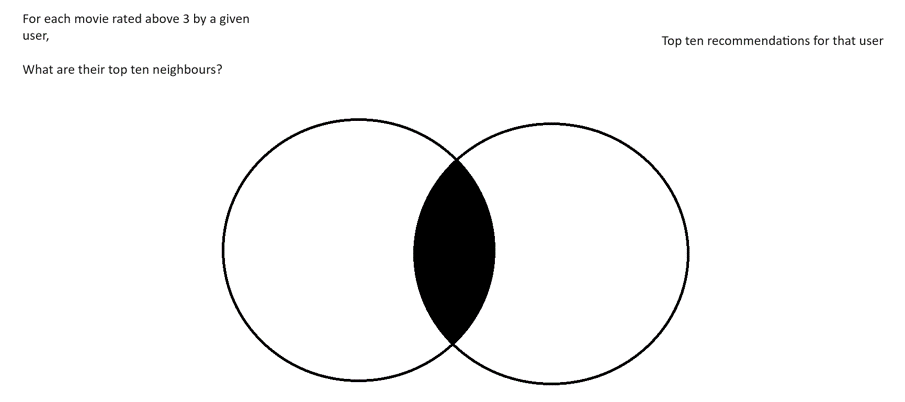

In [74]:
get_top_n(4169)

['General, The (1927)',
 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 '42 Up (1998)',
 'Wrong Trousers, The (1993)',
 'Toy Story (1995)',
 'Close Shave, A (1995)',
 'Grand Day Out, A (1992)',
 'Toy Story 2 (1999)',
 'World of Apu, The (Apur Sansar) (1959)',
 'Modern Affair, A (1995)']

In [75]:
get_common_nearest_nghbours_for_high_rated_movies_by(4169)


['General, The (1927)',
 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Wrong Trousers, The (1993)',
 'Toy Story (1995)',
 'Close Shave, A (1995)',
 'Grand Day Out, A (1992)',
 'Toy Story 2 (1999)']

In [76]:
get_top_n(572)

['Usual Suspects, The (1995)',
 'Big Night (1996)',
 'Much Ado About Nothing (1993)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Crimes and Misdemeanors (1989)',
 'Otello (1986)',
 'Three Ages, The (1923)',
 'Bandits (1997)',
 'Little Voice (1998)',
 'Bananas (1971)']

In [77]:
get_common_nearest_nghbours_for_high_rated_movies_by(572)

['Usual Suspects, The (1995)']

In [78]:
get_top_n(665)

['Ponette (1996)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
 'Blue Sky (1994)',
 'It Happened One Night (1934)',
 'Strangers on a Train (1951)',
 'Lady Eve, The (1941)',
 'Persuasion (1995)',
 'Days of Heaven (1978)',
 "Autumn Tale, An (Conte d'automne) (1998)",
 'Man and a Woman, A (Un Homme et une Femme) (1966)']

In [79]:
get_common_nearest_nghbours_for_high_rated_movies_by(665)

[]

In [80]:
collab_filt_df[(collab_filt_df['userId'] == 665) & (collab_filt_df['rating']>3)][['title', 'rating', 'genres']]

,title,rating,genres
99370,"Shining, The (1980)",4,Horror
99371,Scream (1996),4,Horror|Thriller
99373,"Frighteners, The (1996)",4,Comedy|Horror
99374,"Thing, The (1982)",4,Action|Horror|Sci-Fi|Thriller
99375,Interview with the Vampire (1994),5,Drama|Horror
99378,"Fifth Element, The (1997)",5,Action|Sci-Fi
99379,Nowhere (1997),5,Drama
99380,Jaws (1975),4,Action|Horror
99382,Ghostbusters (1984),5,Comedy|Horror
99384,Halloween (1978),5,Horror


In [81]:
movies[movies['title'].isin(get_top_n(665))][['title', 'genres']]

,title,genres
27,Persuasion (1995),Romance
420,Blue Sky (1994),Drama|Romance
734,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War
884,It Happened One Night (1934),Comedy
1490,Ponette (1996),Drama
2096,Strangers on a Train (1951),Film-Noir|Thriller
2616,"Autumn Tale, An (Conte d'automne) (1998)",Romance
2840,Days of Heaven (1978),Drama
2843,"Lady Eve, The (1941)",Comedy|Romance
2877,"Man and a Woman, A (Un Homme et une Femme) (1966)",Drama|Romance


In [82]:
get_top_n(3883)

['400 Blows, The (Les Quatre cents coups) (1959)',
 'Hearts and Minds (1996)',
 'Celebration, The (Festen) (1998)',
 'Third Man, The (1949)',
 'Killer, The (Die xue shuang xiong) (1989)',
 'Conversation, The (1974)',
 'Apple, The (Sib) (1998)',
 'Grand Illusion (Grande illusion, La) (1937)',
 'To Kill a Mockingbird (1962)',
 'Blade Runner (1982)']

In [83]:
get_common_nearest_nghbours_for_high_rated_movies_by(3883)

['Blade Runner (1982)']

In [84]:
movies[movies['title'].isin(get_top_n(3883))]

,movieId,title,genres,imdbId
536,541,Blade Runner (1982),Film-Noir|Sci-Fi,0083658
1176,1207,To Kill a Mockingbird (1962),Drama,0056592
1181,1212,"Third Man, The (1949)",Mystery|Thriller,0041959
1187,1218,"Killer, The (Die xue shuang xiong) (1989)",Action|Thriller,0097202
1384,1423,Hearts and Minds (1996),Drama,0116506
2269,2360,"Celebration, The (Festen) (1998)",Drama,0154420
2412,2503,"Apple, The (Sib) (1998)",Drama,0156901
2639,2731,"400 Blows, The (Les Quatre cents coups) (1959)",Drama,0053198
3041,3134,"Grand Illusion (Grande illusion, La) (1937)",Drama|War,0028950
3629,3730,"Conversation, The (1974)",Drama|Mystery,0071360


In [85]:
collab_filt_df[(collab_filt_df['userId'] == 3883) & (collab_filt_df['rating']>3)]

,userId,movieId,rating,timestamp,title,genres,imdbId
642471,3883,2997,5,967134212,Being John Malkovich (1999),Comedy,0120601
642473,3883,1265,5,967134285,Groundhog Day (1993),Comedy|Romance,0107048
642475,3883,2858,5,965822230,American Beauty (1999),Comedy|Drama,0169547
642480,3883,2369,4,965822136,Desperately Seeking Susan (1985),Comedy|Romance,0089017
642484,3883,3189,4,965822296,My Dog Skip (1999),Comedy,0156812
642486,3883,1784,4,965822136,As Good As It Gets (1997),Comedy|Drama,0119822
642487,3883,2599,4,967134250,Election (1999),Comedy,0126886
642488,3883,34,4,967134285,Babe (1995),Children's|Comedy|Drama,0112431
